# This is the Saildrone and Oscar collocation code. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr

def get_sat_filename(date):
    dir_sat='F:/data/sat_data/oscar/L4/oscar_third_deg/'
    syr = str(date.dt.year.data)
    sat_filename =dir_sat + 'oscar_vel' + syr + '.nc'
    exists = os.path.isfile(sat_filename)
    return sat_filename, exists


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [2]:
#filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-10_minutes-v1_withloggers_matchedadcp_v3.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-10_minutes-v1_withloggers_matchedadcp_v4.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
#ds_usv = ds_usv.swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30',ds_usv.time[-1].data))  #first part of data is when USV being towed, elminiate
ds_usv['vel_east_30m_ave']=ds_usv.vel_east.sel()
ds_usv = ds_usv.swap_dims({'cell':'cell_depth'})
ds_usv_tem = ds_usv.sel(cell_depth=slice(0,30)).mean('cell_depth')  #make a mean of the top 30 m
ds_usv = ds_usv.isel(cell_depth=0)
ds_usv['vel_east_30m']=ds_usv_tem.vel_east
ds_usv['vel_north_30m']=ds_usv_tem.vel_north
ds_usv['spd_30m']=np.sqrt(ds_usv.vel_east_30m**2+ds_usv.vel_north_30m**2)
ds_usv_subset = ds_usv.copy(deep=True)
#d_usv_subset = ds_usv.isel(cell = 0)
#ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
#ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
#ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
#ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
#ds_usv_subset = ds_usv.dropna(dim='time',subset={'UWND_MEAN'})   #get rid of all the nan
#print(ds_usv_subset.UWND_MEAN[2000:2010].values)

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


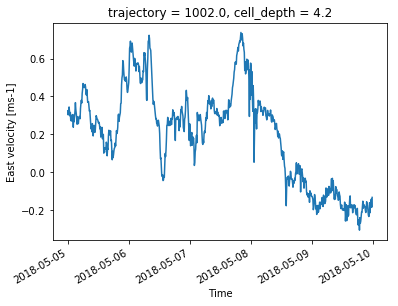

In [3]:
ds_usv.vel_east.sel(time=slice('2018-05-05','2018-05-09')).plot()
#print(ds_usv.vel_east_30m[0].data)
#print(ds_usv2a.vel_east[0].data)  -0.3447692
#print(ds_usv.vel_east[0,0:13].mean().data)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all data for that period

In [4]:
read_date,end_date = ds_usv_subset.time.min(),ds_usv_subset.time.max()
filelist = []
while read_date<=(end_date+np.timedelta64(365,'D')):  #oscar files are in yearly files
    tem_filename,exists = get_sat_filename(read_date)
    if exists:
        filelist.append(tem_filename)
    read_date=read_date+np.timedelta64(365,'D')
print(filelist[0])

F:/data/sat_data/oscar/L4/oscar_third_deg/oscar_vel2018.nc


# Read in OSCAR data
Read in data using open_mfdataset with the option coords='minimal'

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [5]:
#ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat = xr.open_dataset(filelist[0])
ds_sat = ds_sat.isel(depth=0).drop('year').rename({'latitude':'lat'}).rename({'longitude':'lon'})
ds_sat = ds_sat.sortby('lat').sel(lon=slice(20.0,379.00))
ds_sat.coords['lon'] = (ds_sat.coords['lon'] + 180) % 360 - 180
ds_sat = ds_sat.sortby('lon')
ds_sat.close()
ds_sat

<xarray.Dataset>
Dimensions:  (lat: 481, lon: 1078, time: 72)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-06 ... 2018-12-26
    depth    float32 15.0
  * lat      (lat) float64 -80.0 -79.67 -79.33 -79.0 ... 79.0 79.33 79.67 80.0
  * lon      (lon) float64 -180.0 -179.7 -179.3 -179.0 ... 179.0 179.3 179.7
Data variables:
    u        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    v        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    um       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    vm       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    VARIABLE:       Ocean Surface Currents
    DATATYPE:       1/72 YEAR Interval
    DATASUBTYPE:    unfiltered
    GEORANGE:       20 to 420 -80 to 80
    PERIOD:         Jan.01,2018 to Dec.26,2018
    year:           2018
    description:    OSCAR Third Degree Sea Surface Velocity
    CREATION_DATE:  03:39 30-Jan-2019
    vers

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons

1. Now load the data into memory (de-Dask-ify) it  


In [6]:
#Step 1 from above
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
#subset.load()
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [7]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.u[index]):
        continue
    if np.isnan(ds_tem.u[index]):
        continue
   # print(index, ilen)
    iend = index + 300
    if iend > ilen-1:
        iend = ilen-1
    ds_tem_subset = ds_tem.u[index:iend]
    ds_tem_subset2 = ds_tem.v[index:iend]
    ds_usv_subset2ucur = ds_usv_subset.vel_east_30m[index:iend]
    ds_usv_subset2vcur = ds_usv_subset.vel_north_30m[index:iend]
    ds_usv_subset2lat = ds_usv_subset.lat[index:iend]
    ds_usv_subset2lon = ds_usv_subset.lon[index:iend]
    ds_usv_subset2time = ds_usv_subset.time[index:iend]
    cond = ((ds_tem_subset==ds_collocated_nearest.u[index]) & (ds_tem_subset2==ds_collocated_nearest.v[index]))
    notcond = np.logical_not(cond)
    #cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]))
    #notcond = np.logical_not(cond)
    masked = ds_tem_subset.where(cond)
    if masked.sum().data==0:  #don't do if data not found
        continue
    masked_usvucur = ds_usv_subset2ucur.where(cond,drop=True)
    masked_usvvcur = ds_usv_subset2vcur.where(cond,drop=True)
    masked_usvlat = ds_usv_subset2lat.where(cond,drop=True)
    masked_usvlon = ds_usv_subset2lon.where(cond,drop=True)
    masked_usvtime = ds_usv_subset2time.where(cond,drop=True)
    duu=np.append(duu,masked_usvucur.mean().data)
    duv1=np.append(duv1,masked_usvvcur.mean().data)
    dlat=np.append(dlat,masked_usvlat.mean().data)
    dlon=np.append(dlon,masked_usvlon.mean().data)
    tdif = masked_usvtime[-1].data-masked_usvtime[0].data
    mtime=masked_usvtime[0].data+np.timedelta64(tdif/2,'ns')
    if mtime>dut.max():
        print(index,dut.shape[0],masked_usvtime[0].data,masked_usvtime[-1].data-masked_usvtime[0].data)
    dut=np.append(dut,mtime)
    ds_tem.u[index:iend]=ds_tem.u.where(notcond)
    ds_tem.v[index:iend]=ds_tem.v.where(notcond)
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined       
ds_new=xr.Dataset(data_vars={'vel_east': ('time',duu),'vel_north':('time',duv1),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/oscar_downsampled_usv_data2.nc')

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [8]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:  (time: 166)
Coordinates:
    depth    float32 15.0
    lat      (time) float64 37.58 37.32 37.38 36.97 ... 37.3 37.45 37.55 37.64
    lon      (time) float64 -122.7 -122.8 -122.9 -122.7 ... -123.1 -122.9 -122.8
  * time     (time) datetime64[ns] 2018-04-12 ... 2018-06-10T17:55:00
Data variables:
    u        (time) float64 0.02423 0.04211 0.04228 ... -0.05069 -0.0574
    v        (time) float64 0.003738 -0.0401 -0.04799 ... -0.02103 -0.03263
    um       (time) float64 0.02423 0.04211 0.04228 ... -0.05069 -0.0574
    vm       (time) float64 0.003738 -0.0401 -0.04799 ... -0.02103 -0.03263
Attributes:
    VARIABLE:       Ocean Surface Currents
    DATATYPE:       1/72 YEAR Interval
    DATASUBTYPE:    unfiltered
    GEORANGE:       20 to 420 -80 to 80
    PERIOD:         Jan.01,2018 to Dec.26,2018
    year:           2018
    description:    OSCAR Third Degree Sea Surface Velocity
    CREATION_DATE:  03:39 30-Jan-2019
    version:        2009.0
    source:  

In [9]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/oscar_downsampled_collocated_usv_data2.nc')


In [19]:
ds_collocated_averaged['spd']=np.sqrt(ds_collocated_averaged.u**2+ds_collocated_averaged.v**2)
ds_new['spd'] = np.sqrt(ds_new.vel_east**2+ds_new.vel_north**2)
ds_collocated_averaged['dir']=np.arctan2(ds_collocated_averaged.v,ds_collocated_averaged.u)*180./np.pi
ds_new['dir'] = np.arctan2(ds_new.vel_north,ds_new.vel_east)*180./np.pi

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360
print('mean,std dif speed',[dif_spd.mean().data,dif_spd.std().data])
print('mean,std dir',[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]])

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360

cond = (np.isfinite(usv_spd) & np.isfinite(sat_spd))
usv_spd = usv_spd[cond]
sat_spd = sat_spd[cond]
usv_dir = usv_dir[cond]
sat_dir = sat_dir[cond]

sdif = dif_spd.dropna('time')
sdifcor = np.corrcoef(sat_spd,usv_spd)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])
sdif = dif_dir.dropna('time')
sdifcor = np.corrcoef(sat_dir,usv_dir)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])


mean,std dif speed [array(0.11532348), array(0.11499126)]
mean,std dir [array(-0.58433052), array(62.56986319), 166]
[array(0.11532348), array(0.08847356), 0.46312196285688884, array(0.11499126), 0.10283439828708237, array(0.12332252), 156]
[array(-0.58433052), array(1.83418634), 0.34568340567490835, array(62.56986319), 43.74874868529214, array(45.90185041), 156]


1.2880034593823033 0.08742595735992957 0.4631219628568888 1.145882814190053e-09 0.19862749960866638


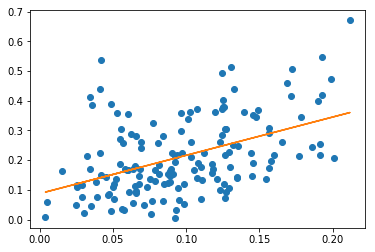

In [30]:

# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api
# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

xi = sat_spd.data
A = array([ xi, ones(sdif.shape[0])])
y = usv_spd.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.plot(xi,y,'o', xi, line)
print(slope,intercept,r_value,p_value,std_err)
#pylab.title('Linear Fit with Matplotlib')
#ax = plt.gca()
#ax.set_axis_bgcolor((0.898, 0.898, 0.898))
#fig = plt.gcf()
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')

0.2632417100512968 -0.0006209413653186771 0.6667250214702602 3.780658889939093e-21 0.023868190066434435
0.25431621164372215 -0.028272310639118704 0.560008662575672 4.3206172130536614e-14 0.030517086920784774


((-0.5, 0.5), (-0.5, 0.5))

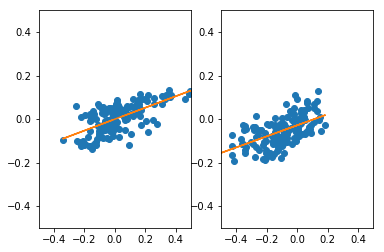

In [45]:
usv_ucur = ds_new.vel_east
usv_vcur = ds_new.vel_north
sat_ucur = ds_collocated_averaged.u
sat_vcur = ds_collocated_averaged.v

cond = (np.isfinite(usv_ucur) & np.isfinite(sat_ucur) & ( usv_vcur<.2))
usv_ucur = usv_ucur[cond]
sat_ucur = sat_ucur[cond]
usv_vcur = usv_vcur[cond]
sat_vcur = sat_vcur[cond]

xi = usv_ucur.data
A = array([ xi, ones(usv_ucur.shape[0])])
y = sat_ucur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(121)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.5,.5),plt.xlim(-.5,.5)
print(slope,intercept,r_value,p_value,std_err)
xi = usv_vcur.data
A = array([ xi, ones(usv_vcur.shape[0])])
y = sat_vcur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(122)
plt.plot(xi,y,'o', xi, line)
print(slope,intercept,r_value,p_value,std_err)
plt.ylim(-.5,.5),plt.xlim(-.5,.5)


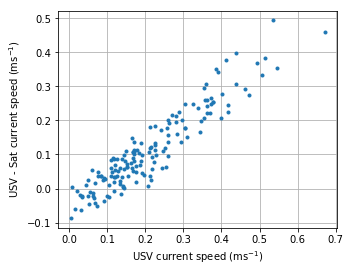

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,dif_spd,'.')
ax.grid(True)
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat current speed (ms$^{-1}$)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_spd_both_bias2.png'
fig.savefig(fig_fname, transparent=False, format='png')


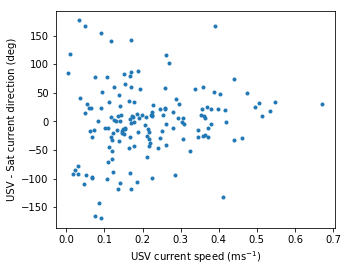

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,dif_dir,'.')
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat current direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


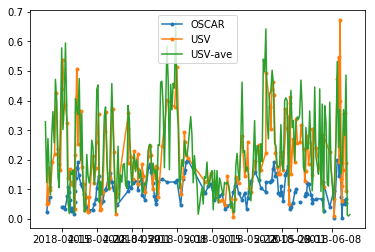

In [13]:
ds_usv_subset['cur_spd']=np.sqrt(ds_usv_subset.vel_east**2+ds_usv_subset.vel_north**2)
ds_usv_6hr=ds_usv_subset.resample(time='6H').mean()
ds_usv_6hr['cur_spd']=np.sqrt(ds_usv_6hr.vel_east**2+ds_usv_6hr.vel_north**2)


plt.plot(ds_collocated_averaged.time,sat_spd,'.-')
plt.plot(ds_collocated_averaged.time,usv_spd,'.-')
plt.plot(ds_usv_6hr.time,ds_usv_6hr.cur_spd)
plt.legend({'OSCAR','USV','USV-ave'})
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_timeseries_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


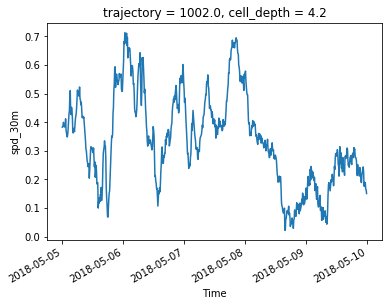

In [35]:
ds_usv.spd_30m.sel(time=slice('2018-05-05','2018-05-09')).plot()


In [ ]:
#faster not sure why
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu,dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.uwnd[index]):
        continue
    test = ds_collocated_nearest.where((ds_tem.uwnd==ds_collocated_nearest.uwnd[index])&(ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
    test = test/test
    if test.uwnd.sum()>0:
        duu=np.append(duu,(ds_usv_subset.UWND_MEAN*test.uwnd).mean().data)
        dvu=np.append(dvu,(ds_usv_subset.VWND_MEAN*test.vwnd).mean().data)
        dlat=np.append(dlat,(ds_usv_subset.lat*test.lat).mean().data)
        dlon=np.append(dlon,(ds_usv_subset.lon*test.lon).mean().data)
        tdif = ds_usv_subset.time.where(test.vwnd==1).max().data-ds_usv_subset.time.where(test.vwnd==1).min().data
        mtime=ds_usv_subset.time.where(test.vwnd==1).min().data+np.timedelta64(tdif/2,'ns')
        dut=np.append(dut,mtime)
        ds_tem=ds_tem.where(np.isnan(test),np.nan)  #you have used values, so set to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new2=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})


In [ ]:
#testing code above
ds_tem = ds_collocated_nearest.copy(deep=True)
print(ds_collocated_nearest.uwnd[1055].data)
print(ds_collocated_nearest.uwnd[1050:1150].data)
test = ds_collocated_nearest.where((ds_collocated_nearest.uwnd==ds_collocated_nearest.uwnd[1055])&(ds_collocated_nearest.vwnd==ds_collocated_nearest.vwnd[1055]))
test = test/test
print(test.uwnd[1050:1150].data)
ds_tem=ds_tem.where(np.isnan(test),np.nan)
print(ds_tem.uwnd[1050:1150].data)
print((ds_usv_subset.UWND_MEAN*test.uwnd).mean())
print((ds_usv_subset.VWND_MEAN*test.vwnd).mean())


In [ ]:
from scipy.interpolate import griddata
# interpolate
points = (ds_usv_subset.lon.data,ds_usv_subset.lat.data)
grid_in_lon,grid_in_lat = np.meshgrid(subset.lon.data,subset.lat.data)
grid_in = (grid_in_lon,grid_in_lat)
values = ds_usv_subset.UWND_MEAN.data
#print(points.size)
zi = griddata(points,values,grid_in,method='linear',fill_value=np.nan)
zi2 = griddata(points,values/values,grid_in,method='linear',fill_value=np.nan)
print(np.isfinite(zi).sum())

In [ ]:
plt.pcolormesh(subset.lon,subset.lat,zi,vmin=-5,vmax=5)
plt.plot(ds_usv_subset.lon,ds_usv_subset.lat,'.')
#plt.contourf(subset.uwnd[0,:,:])

In [ ]:
len(points[0])

In [ ]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

THRESHOLD=1
# Construct kd-tree, functionality copied from scipy.interpolate
tree = cKDTree(points)
xi = _ndim_coords_from_arrays(grid_in, ndim=len(points[0]))
dists, indexes = tree.query(xi)

# Copy original result but mask missing values with NaNs
result3 = result2[:]
result3[dists > THRESHOLD] = np.nan

# Show
plt.figimage(result3)
plt.show()

In [ ]:
#testing
index=300
ds_tem = ds_collocated_nearest.copy(deep=True)
cond = ((ds_tem.uwnd==ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
notcond = ((ds_tem.uwnd!=ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd!=ds_collocated_nearest.vwnd[index]))
masked = ds_tem.where(cond)
masked_usv = ds_usv_subset.where(cond,drop=True)
print(masked.uwnd.sum().data)
#print(masked.nobs[290:310].data)
print((masked_usv.UWND_MEAN).mean().data)
print(ds_tem.uwnd[243:316])
ds_tem=ds_tem.where(notcond,np.nan)  #you have used values, so set to nan
print(ds_tem.uwnd[243:316])
